<h3> Importing Libraries </h3>

In [103]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt

<h3> Loading +/- Data </h3>

In [104]:
# Load positive and negative data sets as dataframe
positive_data = pd.read_csv('../deep_annotator_data/positive_sample.txt', header=None, nrows=2000)
positive_data.columns = ["Gene"]
negative_data = pd.read_csv('../deep_annotator_data/negative_sample.txt', header=None, nrows=2000)
negative_data.columns = ["Gene"]
data_ = pd.concat([positive_data, negative_data])
positive_test_data = pd.read_fwf('positive_sample_test.txt', header = None)
positive_test_data.columns = ["Gene"]
negative_test_data = pd.read_fwf('negative_sample_test.txt', header = None)
negative_test_data.columns = ["Gene"]
data_test = pd.concat([positive_test_data, negative_test_data])

<h3> Hyper Parameters </h3>

In [105]:
batch_size = 1
embedding_size = 5
window = 1
fc_layer_size = (len(positive_data.Gene[0])-(window-1))*embedding_size
hidden_layer_size = 100
num_layers = 2
epochs = 800
lr = 0.008

<h3> Generate word IDs <h3>

In [106]:
strings = set()
def allLexicographicRecur (string, data, last, index): 
    length = len(string)
    for i in range(length): 
        data[index] = string[i] 
        if index==last:
            res = ''.join(data)
            strings.add(res)
        else: 
            allLexicographicRecur(string, data, last, index+1) 
def allLexicographic(string, n): 
    length = len(string)
    data = [""] * (length+1)
    string = sorted(string) 
    allLexicographicRecur(string, data, window-1, 0)
string = "01234"
allLexicographic(string, window)
strings = sorted(strings)
vocabulary = {}
for val, i in enumerate(strings):
    vocabulary[i] = val
print(vocabulary)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


<h3> Generate Word Embeddings </h3>

In [107]:
# embeds = nn.Embedding(len(vocabulary), 5)
# embeddings = {}
# def generate_embeddings():
#     for word in vocabulary:
#         embeddings[word] = embeds(torch.tensor(vocabulary[word], dtype=torch.long)).type(torch.LongTensor)

# generate_embeddings()
# print(embeddings['0'].type())

In [108]:
def generate_samples(data_sample):
    list_of_tensors = []
    for data in data_sample.itertuples():
        for i in range(len(data.Gene) - window + 1):
            if i == 0:
                first_tensor = embeddings[data.Gene[i:i+window]]
            else:
                first_tensor = torch.cat((first_tensor, embeddings[data.Gene[i:i+window]]), 0)
        list_of_tensors.append(first_tensor)
    trainpositives = torch.stack(list_of_tensors)
    return trainpositives

# positives = generate_samples(positive_data)
# print(positives.type())
# negatives = generate_samples(negative_data)
# print(negatives.type())
# data_ = torch.cat([positives, negatives], dim=0)
# print(data_.type())

negative_labels = torch.zeros(2000, 1)
positive_labels = torch.ones(2000, 1)
labels_ = torch.cat([positive_labels, negative_labels], dim=0)

<h3> Neural Network Layer Implementation </h3>

In [115]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embeds = nn.Embedding(len(vocabulary), 5)
        self.lstm = nn.LSTM(fc_layer_size, fc_layer_size, num_layers)
        self.fc1 = nn.Linear(fc_layer_size, hidden_layer_size)
        self.dropout = nn.Dropout(p=0.4)
        self.relu1 = nn.Sigmoid()
        self.out = nn.Linear(hidden_layer_size, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        h = autograd.Variable(torch.randn(num_layers, 1, fc_layer_size))
        c = autograd.Variable(torch.randn(num_layers, 1, fc_layer_size))
        z = self.embeds(x).view((1,-1))
#         print(z)
        out_lstm, hn = self.lstm(z, (h, c))
        a1 = self.fc1(z)
        d1 = self.dropout(a1)
        h1 = self.relu1(a1)
        a3 = self.out(h1)
        y = self.out_act(a3)
        return y
net = Net()

<h4> Optimizer step and loss calculation </h4>

In [116]:
opt = optim.SGD(net.parameters(), lr, momentum=0.0)
criterion = nn.BCELoss()

<h4> Train method </h4>

In [117]:
def train_epoch(model, opt, criterion, batch_size=1):
    model.train()
    losses = []
    c = 0
    wrong, correct = 0, 0
    for data in data_.itertuples():
        
        data_batch = torch.tensor([vocabulary[data.Gene[i:i+window]] for i in range(0, len(data.Gene) - window + 1)], dtype=torch.long)
        labels_batch = labels_[c]
        c+=1
        data_batch = autograd.Variable(data_batch)
        labels_batch = autograd.Variable(labels_batch)

        opt.zero_grad()
        
        # Extend the side of the data_batch to adhere to LSTM layer implementation
        # data_batch.unsqueeze_(0)
        # data_batch = data_batch.expand(1, batch_size, fc_layer_size)
        labels_hat = net(data_batch)
        
        # Compute the binary Cross Entropy Loss
        loss = criterion(labels_hat, labels_batch)

        loss.backward()

        opt.step()        
        losses.append(loss.data.numpy())
        correct, wrong = get_train_accuracy(labels_hat, c, len(labels_), correct, wrong)
    loss = sum(losses)/len(losses)
    return loss,correct,wrong

<h4> Train Accuracy </h4>

In [118]:
def get_train_accuracy(label, index, data_size, correct, wrong):    
    if index < data_size/2+1:
        if label > 0.5:
            correct += 1
        else:
            wrong += 1
    else:
        if label > 0.5:
            wrong += 1
        else:
            correct += 1
    return correct, wrong

In [122]:
def train():
    losses = []
    accuracies = []
    test_acc = []
    for e in range(epochs):
        loss, c, w = train_epoch(net, opt, criterion, batch_size)
        accuracies.append(100*(c/(c+w)))
        losses.append(loss)
        if e % 20 == 0:
            print('Average Loss at epoch,',e,':',loss)
        torch.save(net.state_dict(), 'fc_with_lstm.pt')
        correct, wrong = load_test_model()
        test_acc.append(100*(correct/(correct+wrong)))
    plt.plot(losses)
    return accuracies, test_acc
acc,test = train()

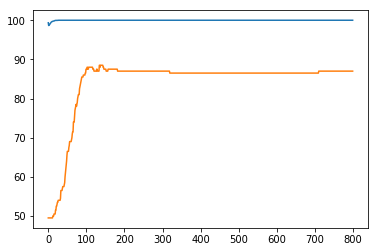

In [121]:
plt.plot(acc)
plt.plot(test)

<h3> Test Data Prediction </h3>

<h4> Load the Model and test data </h4>

In [88]:
def load_test_model():
    #load model
    model = Net()
    model.load_state_dict(torch.load('fc_with_lstm.pt'))
    model.eval()
    # load data
    labels_predicted = []
    return test_prediction_model(data_test, labels_predicted)

<h4> Generate output labels for test predictions </h4>

In [89]:
def test_prediction_model(data_test, labels_predicted):
    correct, wrong = 0, 0
    for data in data_test.itertuples():
        data_testing = torch.tensor([vocabulary[data.Gene[i:i+window]] for i in range(0, len(data.Gene) - window + 1)], dtype=torch.long)
        # data_test_.unsqueeze_(0)
        # data_testing = data_test_.expand(1, batch_size, fc_layer_size)
        labels_hat = net(data_testing)
        labels_predicted.append(labels_hat[0])
    for i in range(len(labels_predicted)//2 + 1):
        if labels_predicted[i] > 0.5:
            correct += 1
        else:
            wrong += 1
    for i in range(101, len(labels_predicted)):
        if labels_predicted[i] > 0.5:
            wrong += 1
        else:
            correct += 1
    return correct,wrong
    

<h4> Accuracy for Test predictions </h4>

In [90]:
def test_prediction_accuracy(labels):
    correct, wrong = 0, 0
    labels_hat = labels
    for i in range(len(labels_hat)//2 + 1):
        if labels_hat[i] > 0.5:
            correct += 1
        else:
            wrong += 1
    for i in range(101, len(labels_hat)):
        if labels_hat[i] > 0.5:
            wrong += 1
        else:
            correct += 1
    return (correct,wrong)

In [123]:
batch_size = 100
embedding_size = 5
fc_layer_size = (len(positive_data.Gene[0])-(window-1))*embedding_size
hidden_layer_size = 100
num_layers = 2
epochs = 500
lr = 0.02
# train()
# labels = []
# test_prediction_model(data_test, labels)
# results = test_prediction_accuracy(labels)
# print("Correct Predictions:", results[0])
# print("Wrong Predictions:", results[1])